In [1]:
import pandas as pd
from Preprocessing.MECO_data_split import concat_MECO_langs

ru = concat_MECO_langs(['ru'])

In [2]:
from Preprocessing.MECO_data_split import concat_MECO_langs, split_into_time_series
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [4]:
data = concat_MECO_langs(['ru'])
X, y, demo = split_into_time_series(data, test_size=0)

In [5]:
print(X.shape, y.shape)

(439, 180, 3) (439, 1)


In [6]:
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [8]:
def train_model(conv_filters=64, kernel_size=3, strides=1, dropout_rate=0.5, pool_size=2, epochs=10, batch_size=32):
    model = Sequential()
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, strides=strides,
                     activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, strides=strides, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    return model

Epoch 1/10


2023-05-14 13:08:55.327237: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 1s 7ms/step - loss: 90.0497 - accuracy: 0.4217
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 12.8456 - accuracy: 0.5897
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 5.2343 - accuracy: 0.6353
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 2.4638 - accuracy: 0.6809
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 1.5415 - accuracy: 0.7293
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 1.0050 - accuracy: 0.7607
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6568 - accuracy: 0.7863
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5127 - accuracy: 0.8405
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.4358 - accuracy: 0.8519
Epoch 10/10
11/11 [==============================] - 0s 7ms/step - loss: 0.4281 - accuracy: 0.8775


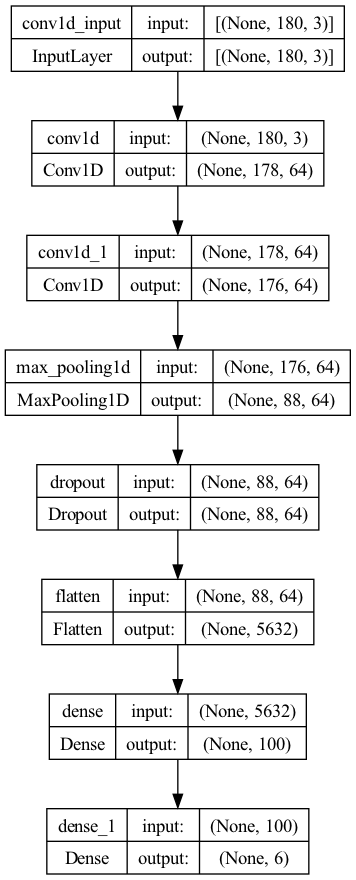

In [9]:
tf.keras.utils.plot_model(train_model(), to_file='kek.png', show_shapes=True)

In [10]:
cnn = train_model(epochs=8, batch_size=32, dropout_rate=0.5, conv_filters=64, kernel_size=3)

Epoch 1/8
11/11 [==============================] - 1s 9ms/step - loss: 190.7408 - accuracy: 0.4615
Epoch 2/8
11/11 [==============================] - 0s 7ms/step - loss: 34.2587 - accuracy: 0.5328
Epoch 3/8
11/11 [==============================] - 0s 7ms/step - loss: 7.8726 - accuracy: 0.6011
Epoch 4/8
11/11 [==============================] - 0s 7ms/step - loss: 3.6347 - accuracy: 0.6325
Epoch 5/8
11/11 [==============================] - 0s 7ms/step - loss: 1.9146 - accuracy: 0.6695
Epoch 6/8
11/11 [==============================] - 0s 7ms/step - loss: 1.7057 - accuracy: 0.7009
Epoch 7/8
11/11 [==============================] - 0s 7ms/step - loss: 1.2086 - accuracy: 0.7037
Epoch 8/8
11/11 [==============================] - 0s 7ms/step - loss: 0.9847 - accuracy: 0.7236


In [12]:
loss, accuracy = cnn.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 1.1366 - accuracy: 0.5682
